In [6]:
from diffprivlib.mechanisms import Laplace as LaplaceMech
from diffprivlib.mechanisms import GaussianAnalytic as GaussianMech
import pickle
import matplotlib.pyplot as plt

import pandas as pd

from dp_policy.titlei.utils import get_saipe, get_sppe
from dp_policy.titlei.bootstrap import Sampled, collect_results

plt.style.use('seaborn-deep')

pd.options.mode.chained_assignment = None

num_bins = 10

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
NUM_RUNS = 100

saipe = get_saipe("../data/saipe19.xls")
sppe = get_sppe("../data/sppe18.xlsx")

# nonprivate
mech = Sampled(saipe)
results, results_nondp = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
with open('../results/bootstrap/results_nondp.pkl', 'wb') as handle:
    pickle.dump(results_nondp, handle)
results.to_csv('../results/bootstrap/results_nondp.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
delta = 1e-6
for epsilon in [2.52]:
    # Laplace
    mech = Sampled(saipe, mechanism=LaplaceMech, epsilon=epsilon, delta=delta)
    results, results_laplace = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    with open('../results/bootstrap/results_laplace_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_laplace, handle)
    results.to_csv('../results/bootstrap/results_laplace_eps={}.csv'.format(epsilon))

    # Gaussian
    mech = Sampled(saipe, mechanism=GaussianMech, epsilon=epsilon, delta=delta)
    results, results_gaussian = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    with open('../results/bootstrap/results_gaussian_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_gaussian, handle)
    results.to_csv('../results/bootstrap/results_gaussian_eps={}.csv'.format(epsilon))

(                                                                                   true_grant_basic  \
State FIPS Code District ID State Postal Code Name                                                    
1               190         AL                Alabaster City School District           1.085565e+06   
                5           AL                Albertville City School District         1.600748e+06   
                30          AL                Alexander City City School District      1.175889e+06   
                60          AL                Andalusia City School District           6.791052e+05   
                90          AL                Anniston City School District            1.768015e+06   
...                                                                                             ...   
56              4260        WY                Uinta County School District 6           7.025227e+04   
                6240        WY                Washakie County School Dis

In [32]:
col_grant = "basic" # choices: basic, targeted, concentration, total
epsilon = 0.01

In [33]:
with open("../results/bootstrap/results_nondp.pkl", 'rb') as handle:
    results_sampling = pickle.load(handle)

path_laplace = "../results/bootstrap/results_laplace_eps={}.pkl".format(epsilon)
with open(path_laplace, 'rb') as handle:
    results_laplace = pickle.load(handle)

path_gaussian = "../results/bootstrap/results_gaussian_eps={}.pkl".format(epsilon)
with open(path_gaussian, 'rb') as handle:
    results_gaussian = pickle.load(handle)

[576. 580. 588. 604. 573. 586. 621. 605. 595. 590. 605. 610. 560. 564.
 601. 602. 571. 630. 579. 559. 573. 598. 557. 587. 604. 586. 632. 566.
 613. 561. 538. 580. 553. 608. 584. 553. 611. 546. 565. 602. 614. 565.
 608. 617. 576. 568. 604. 610. 601. 600. 597. 588. 554. 579. 619. 625.
 593. 565. 626. 600. 611. 606. 595. 587. 607. 589. 589. 606. 597. 579.
 566. 595. 593. 644. 577. 582. 594. 585. 593. 593. 590. 578. 564. 584.
 569. 597. 566. 606. 563. 593. 570. 589. 573. 631. 576. 570. 583. 589.
 617. 595.]


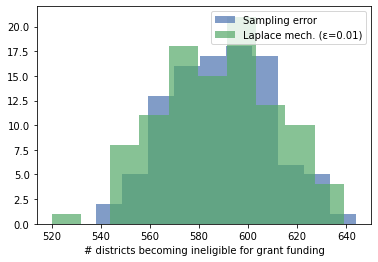

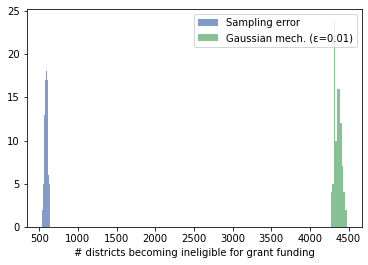

In [34]:
# Number ineligible

quantile = 'sum'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_eligible_{}".format(col_grant)].values
print(x)

y = df_laplace["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

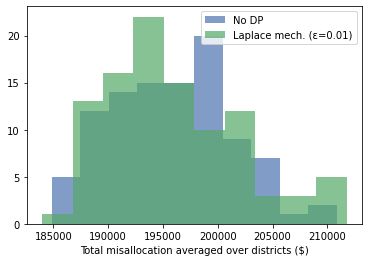

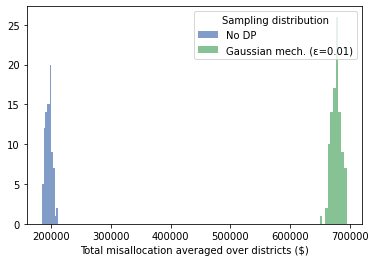

In [37]:
# Average misallocation

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format(col_grant)].values

y = df_laplace["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

y = df_gaussian["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

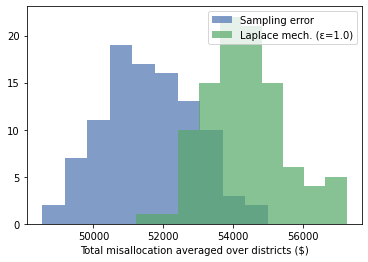

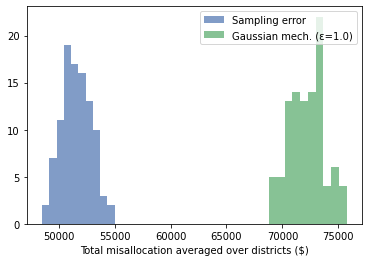

In [ ]:
# Average misallocation (sum of all three grant types)

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format('basic')].values + \
    df_sampling["diff_grant_{}".format('targeted')].values + \
    df_sampling["diff_grant_{}".format('concentration')].values

y = df_laplace["diff_grant_{}".format('basic')].values + \
    df_laplace["diff_grant_{}".format('targeted')].values + \
    df_laplace["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_grant_{}".format('basic')].values + \
    df_gaussian["diff_grant_{}".format('targeted')].values + \
    df_gaussian["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()